In [1]:
# %%
from pathlib import Path
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt


In [2]:
# %% Find data folder
def find_directory(target_dir):
    return next((p / target_dir for p in Path.cwd().parents if (p / target_dir).is_dir()), None) or Path(target_dir)

# Define the path to the data folder
data_dir = find_directory('data')
print(f'{data_dir=}')


data_dir=PosixPath('/home/msugar_dsi_2024_08_gmail_com/team_3_project/data')


In [3]:
# %%
# Load the data
raw_data_dir = data_dir / 'raw'
train_data = pd.read_csv(raw_data_dir / 'Training.csv') 
test_data = pd.read_csv(raw_data_dir / 'Testing.csv')


In [4]:
# %%
# Drop unnamed last column containing all NaNs
train_data.dropna(how='all', axis='columns', inplace=True)
assert train_data.shape == (4920,133), "Training data should have 4920 rows and 133 cols after all NaNs col is removed"
print(train_data.columns)


Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'blackheads', 'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis'],
      dtype='object', length=133)


In [5]:
# %%
# Separate features and labels
label_col = "prognosis"
X_train = train_data.drop(label_col, axis=1)
y_train = train_data[label_col]
X_test = test_data.drop(label_col, axis=1)
y_test = test_data[label_col]


In [6]:
# %%
# Encode prognoses
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


In [7]:
# %%
# Train a model for each prognosis and evaluate
prognoses = le.classes_
n_prognoses = len(prognoses)
models = []
evaluation_results = []

for i in range(n_prognoses):
    prognosis_name = prognoses[i]
    print(f"Training and evaluating model for: {prognosis_name}")
    
    # Create binary target: 1 for current prognosis, 0 for others
    y_train_binary = (y_train_encoded == i).astype(int)
    y_test_binary = (y_test_encoded == i).astype(int)
    
    # Train XGBoost model
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train_binary)
    models.append(model)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Evaluate model
    accuracy = accuracy_score(y_test_binary, y_pred)
    precision = precision_score(y_test_binary, y_pred, zero_division=0)
    recall = recall_score(y_test_binary, y_pred, zero_division=0)
    f1 = f1_score(y_test_binary, y_pred, zero_division=0)
    auc_roc = roc_auc_score(y_test_binary, y_pred_proba)
    
    evaluation_results.append({
        'Prognosis': prognosis_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc
    })


Training and evaluating model for: (vertigo) Paroymsal  Positional Vertigo
Training and evaluating model for: AIDS
Training and evaluating model for: Acne
Training and evaluating model for: Alcoholic hepatitis
Training and evaluating model for: Allergy
Training and evaluating model for: Arthritis
Training and evaluating model for: Bronchial Asthma
Training and evaluating model for: Cervical spondylosis
Training and evaluating model for: Chicken pox
Training and evaluating model for: Chronic cholestasis
Training and evaluating model for: Common Cold
Training and evaluating model for: Dengue
Training and evaluating model for: Diabetes 
Training and evaluating model for: Dimorphic hemmorhoids(piles)
Training and evaluating model for: Drug Reaction
Training and evaluating model for: Fungal infection
Training and evaluating model for: GERD
Training and evaluating model for: Gastroenteritis
Training and evaluating model for: Heart attack
Training and evaluating model for: Hepatitis B
Trainin

In [8]:
# %%
# Convert evaluation results to DataFrame
eval_df = pd.DataFrame(evaluation_results)
print(eval_df)


                                  Prognosis  Accuracy  Precision  Recall  \
0   (vertigo) Paroymsal  Positional Vertigo   1.00000        1.0     1.0   
1                                      AIDS   1.00000        1.0     1.0   
2                                      Acne   1.00000        1.0     1.0   
3                       Alcoholic hepatitis   1.00000        1.0     1.0   
4                                   Allergy   1.00000        1.0     1.0   
5                                 Arthritis   1.00000        1.0     1.0   
6                          Bronchial Asthma   1.00000        1.0     1.0   
7                      Cervical spondylosis   1.00000        1.0     1.0   
8                               Chicken pox   0.97619        0.5     1.0   
9                       Chronic cholestasis   1.00000        1.0     1.0   
10                              Common Cold   1.00000        1.0     1.0   
11                                   Dengue   1.00000        1.0     1.0   
12          

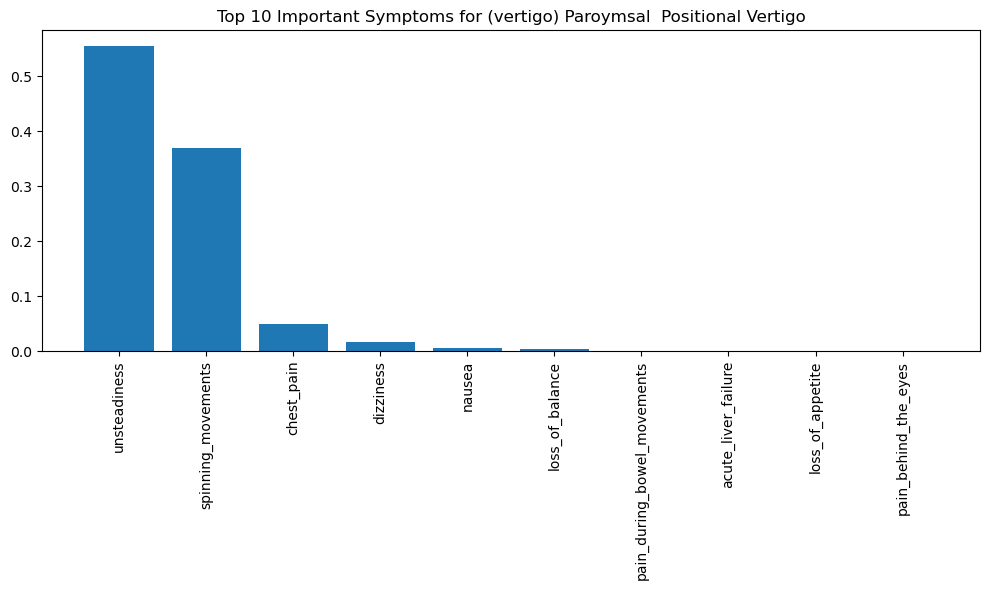

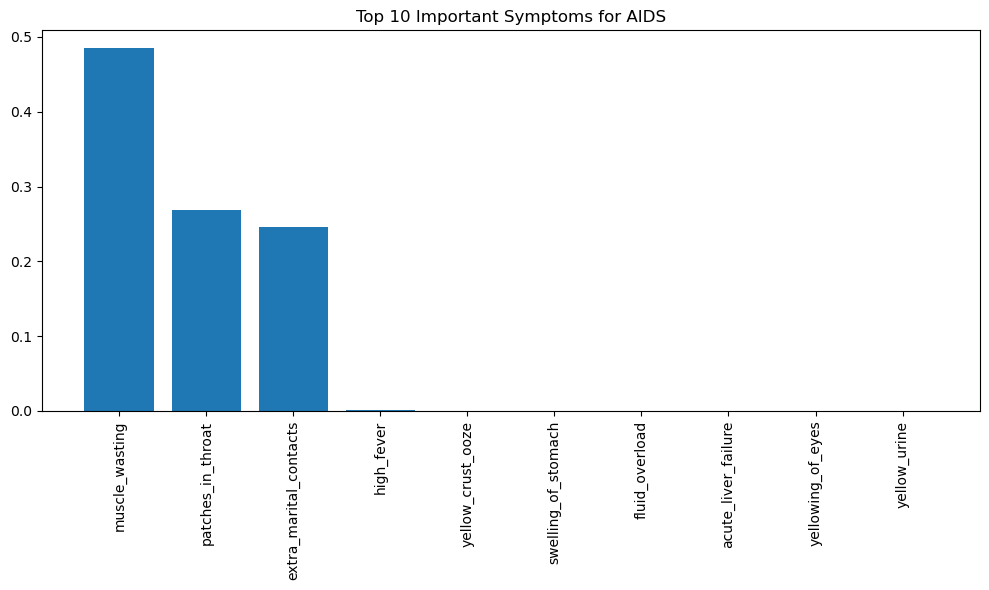

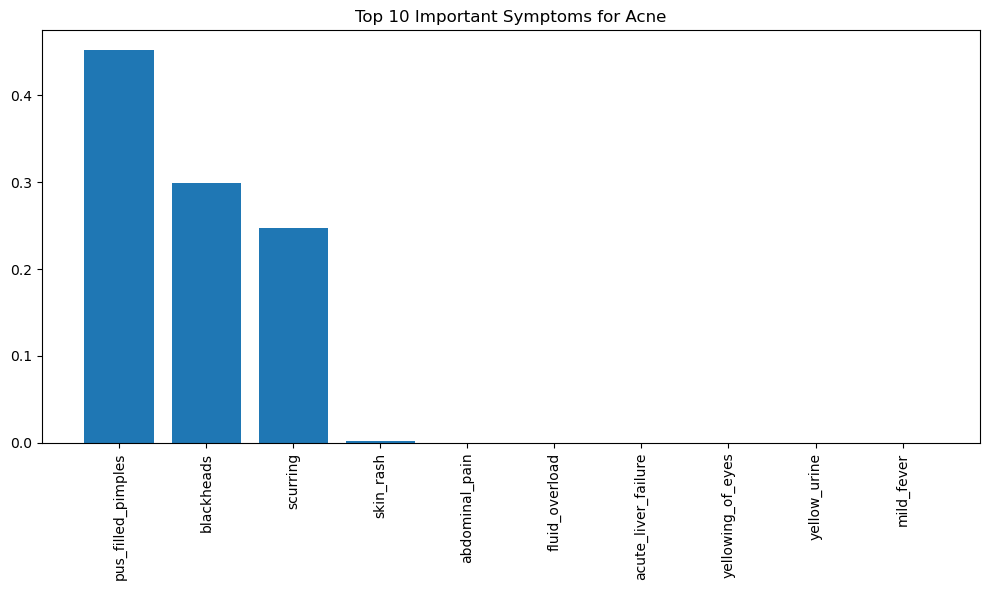

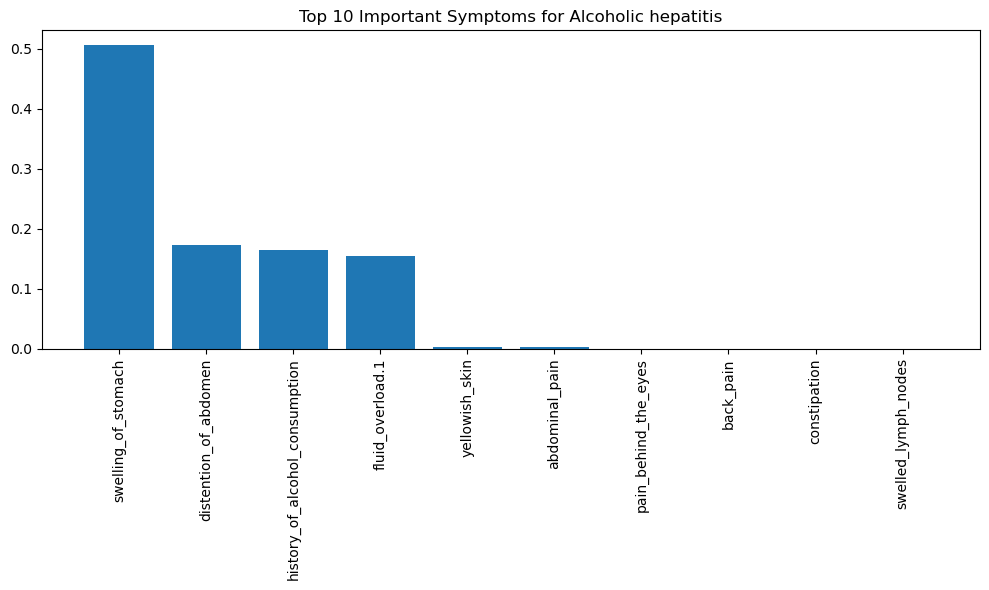

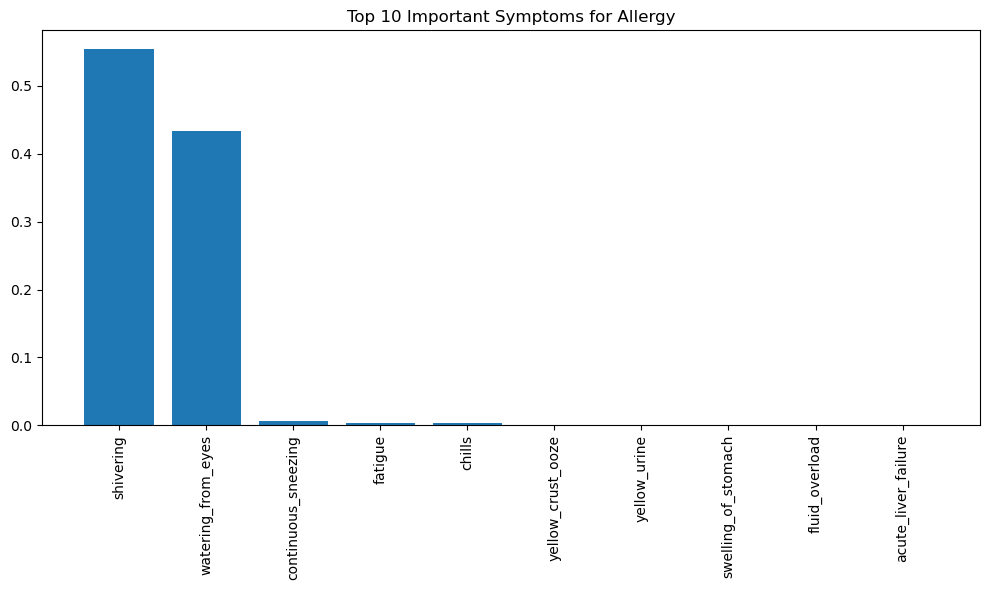

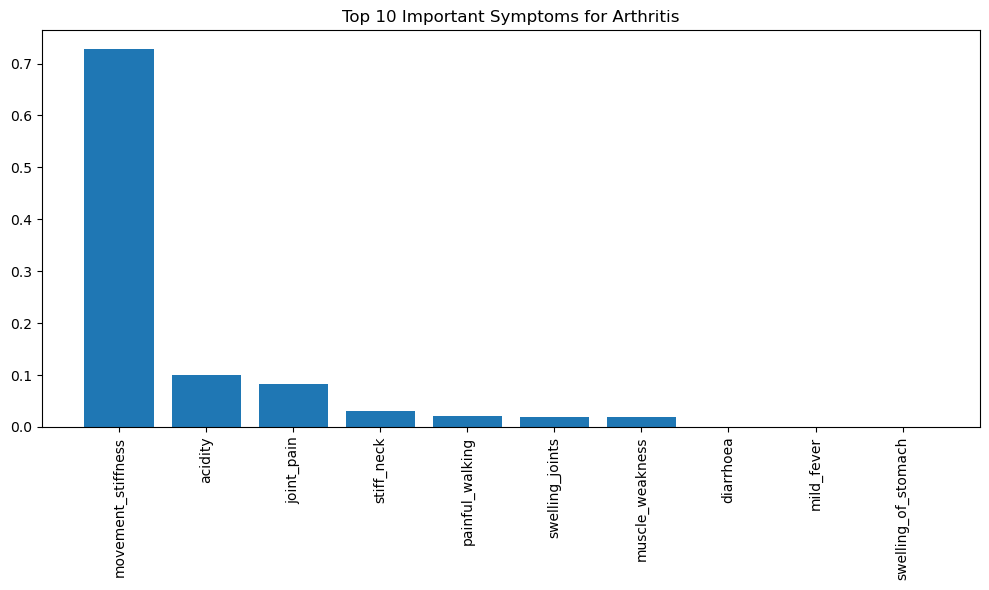

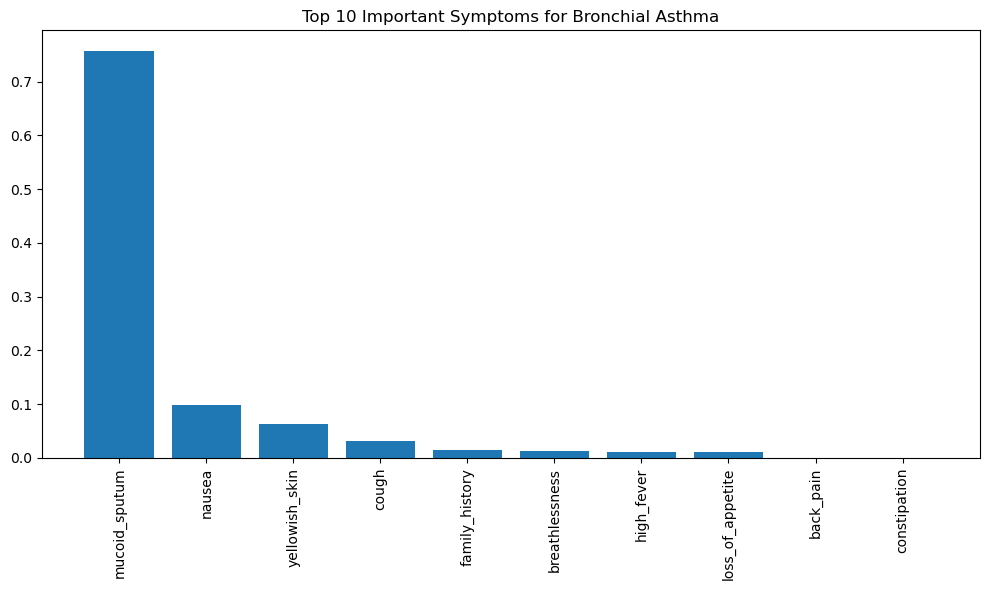

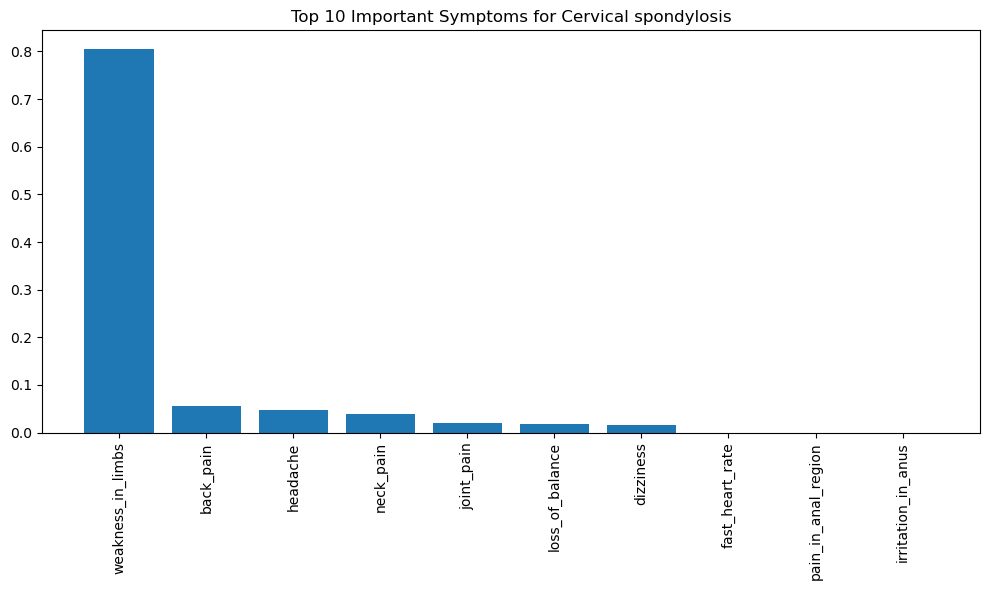

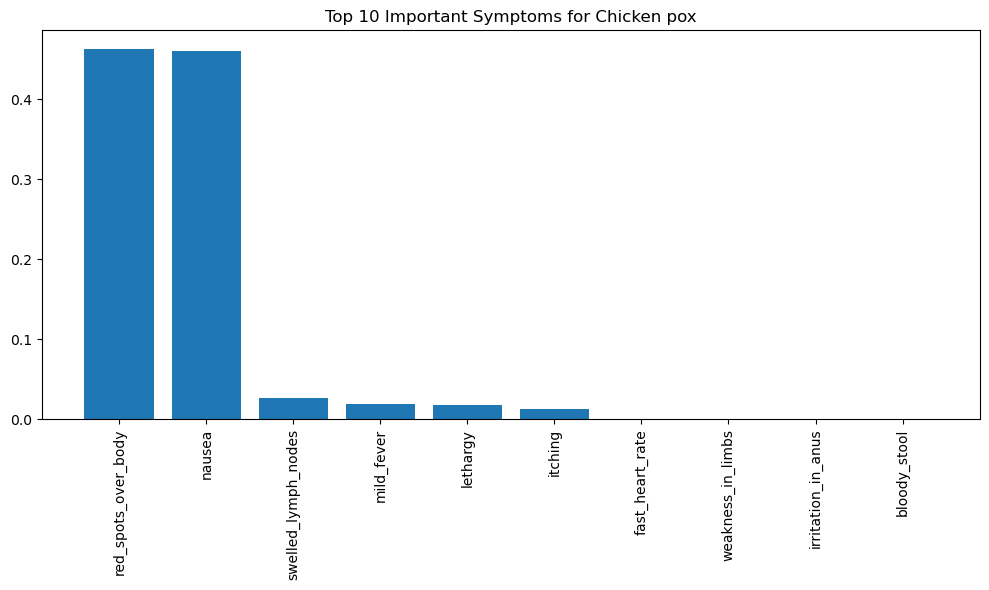

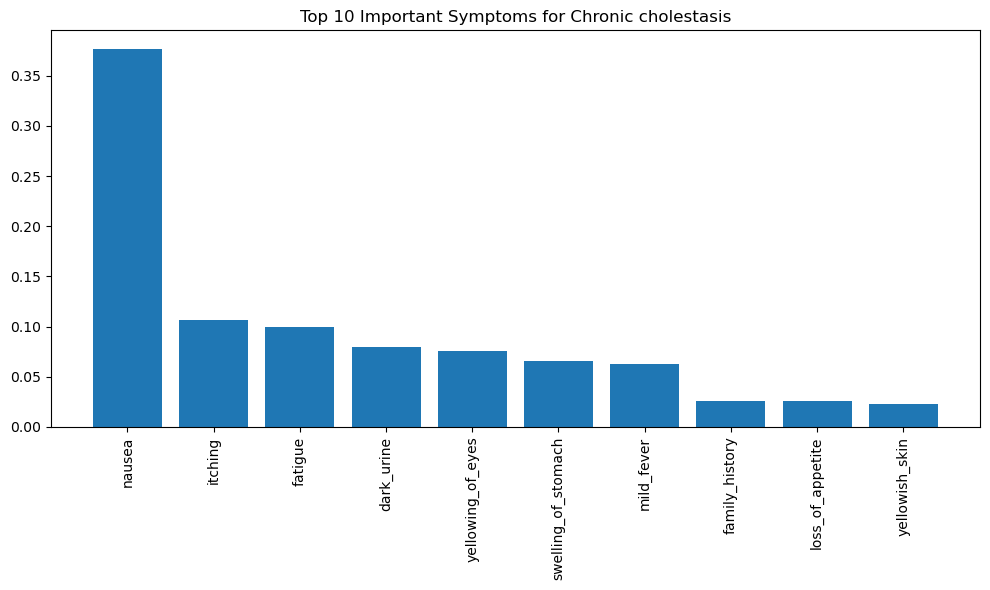

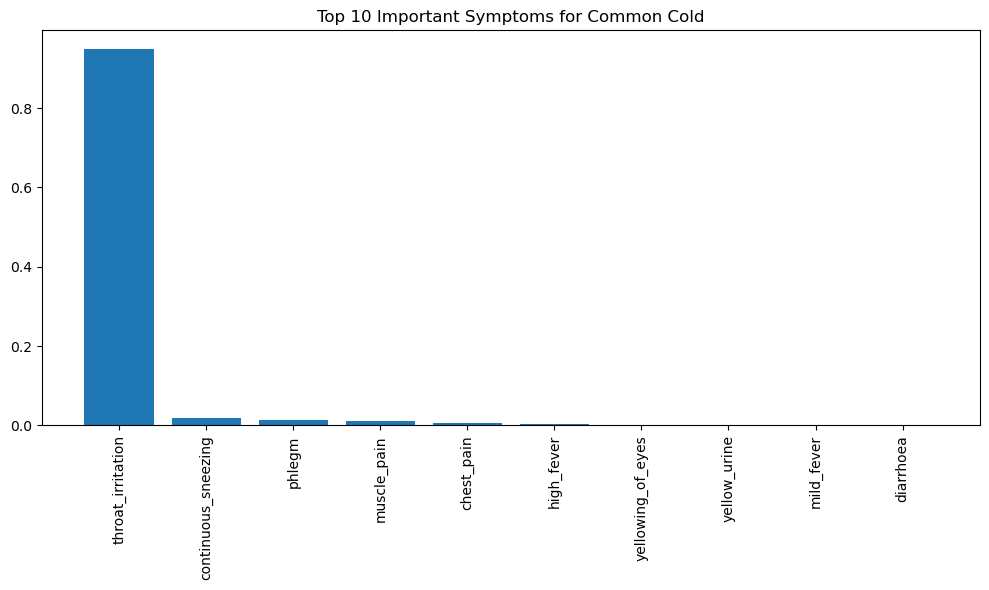

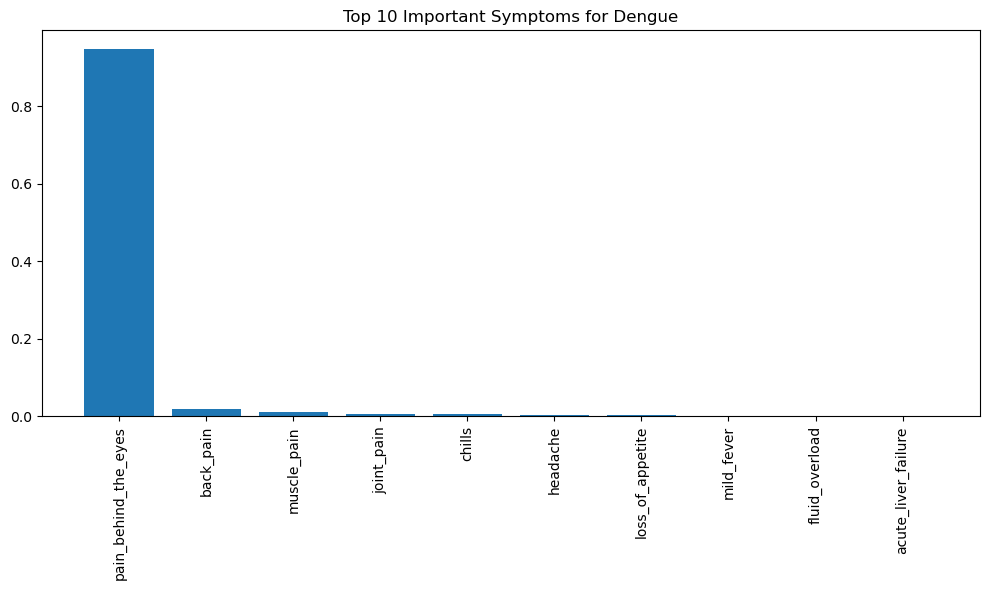

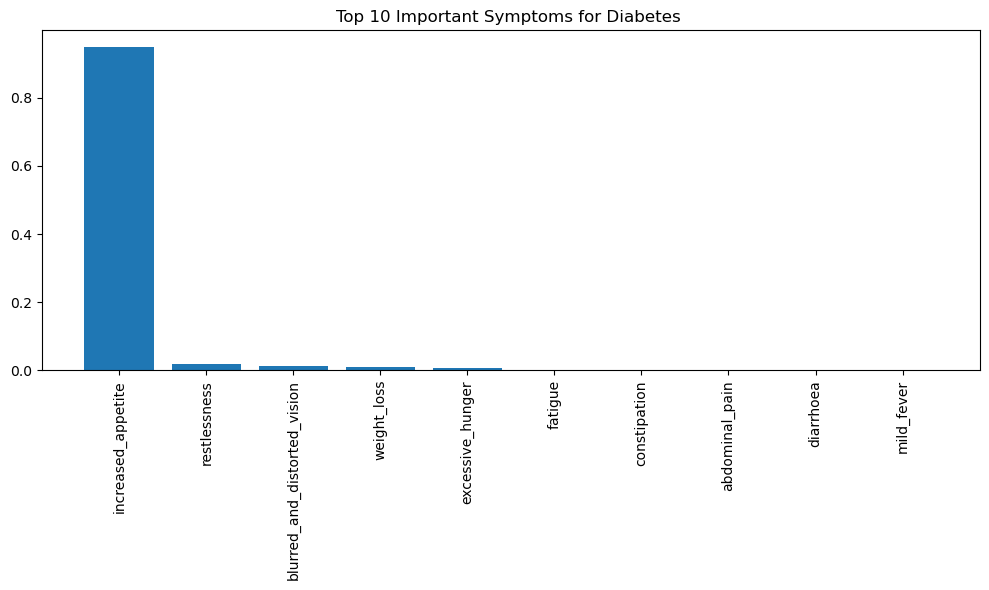

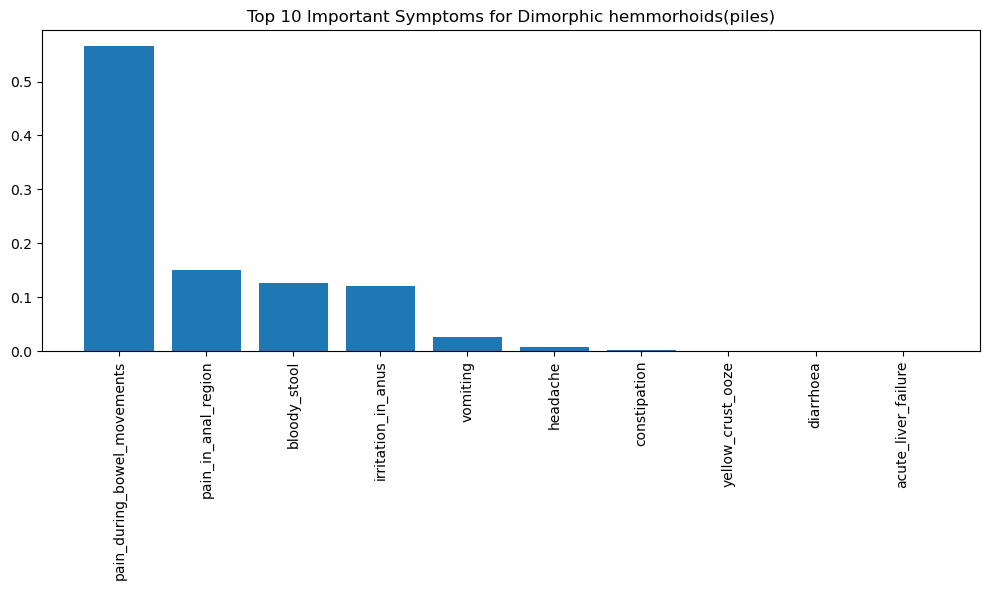

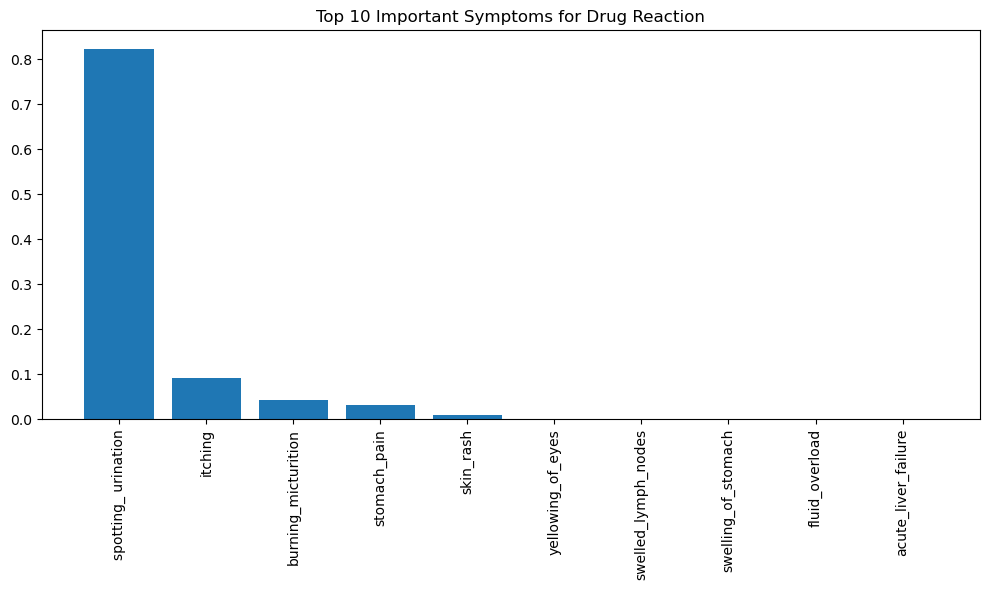

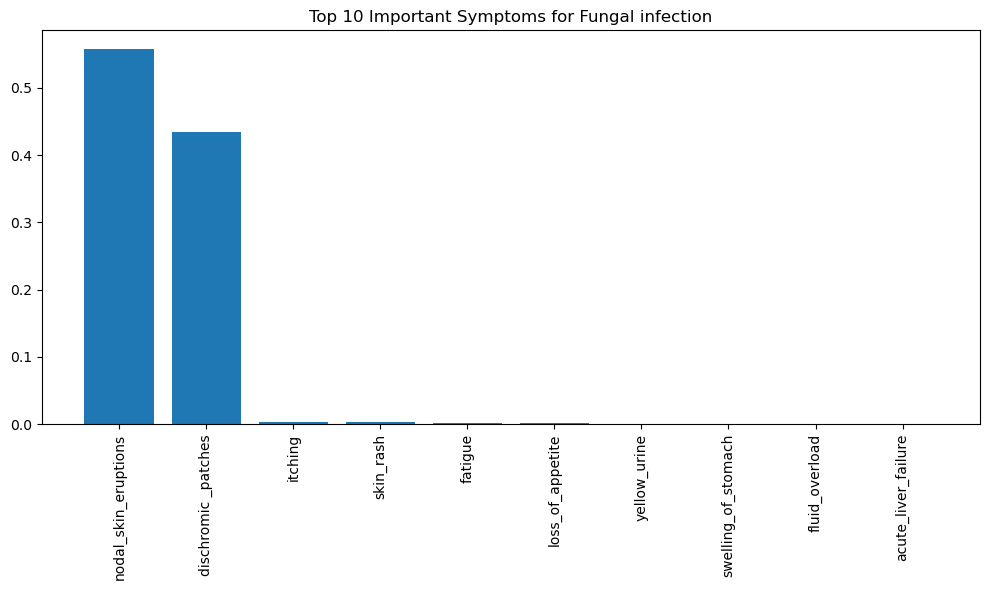

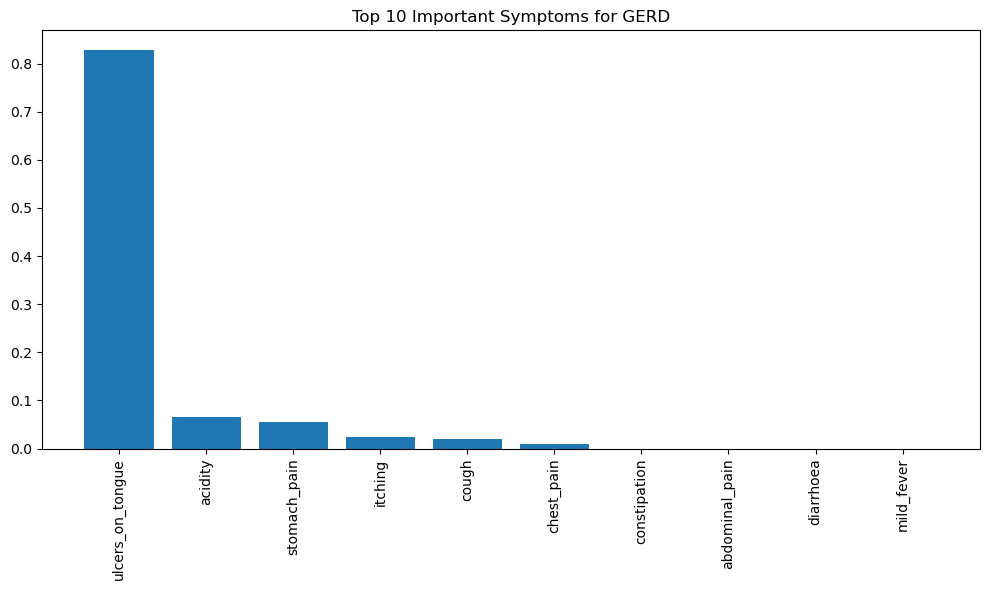

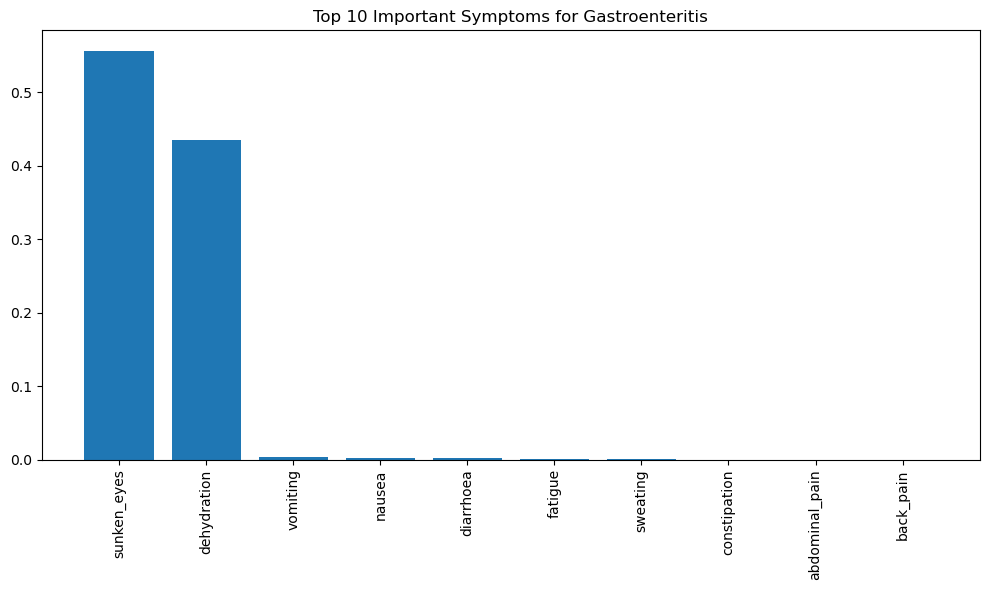

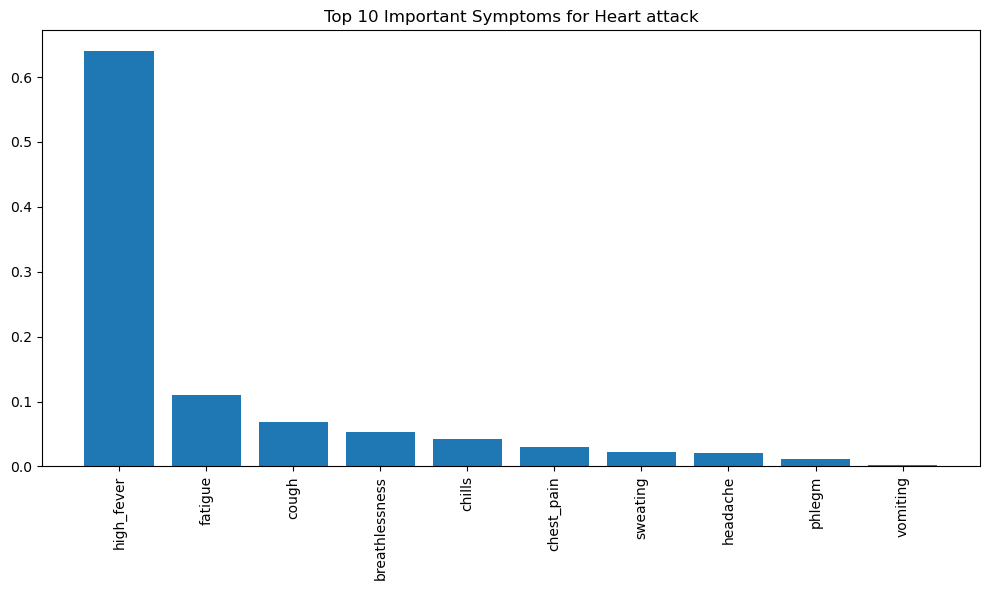

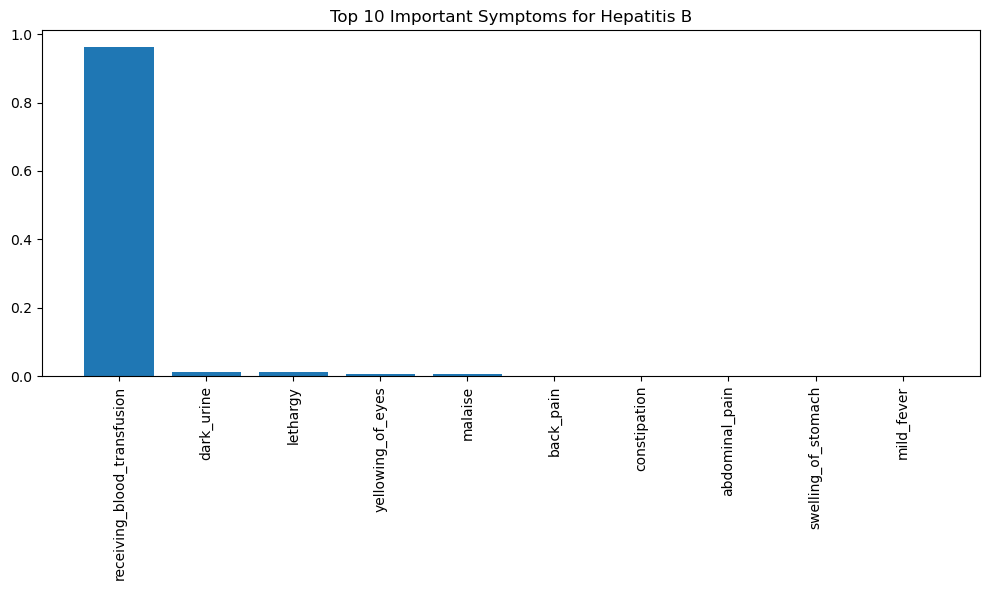

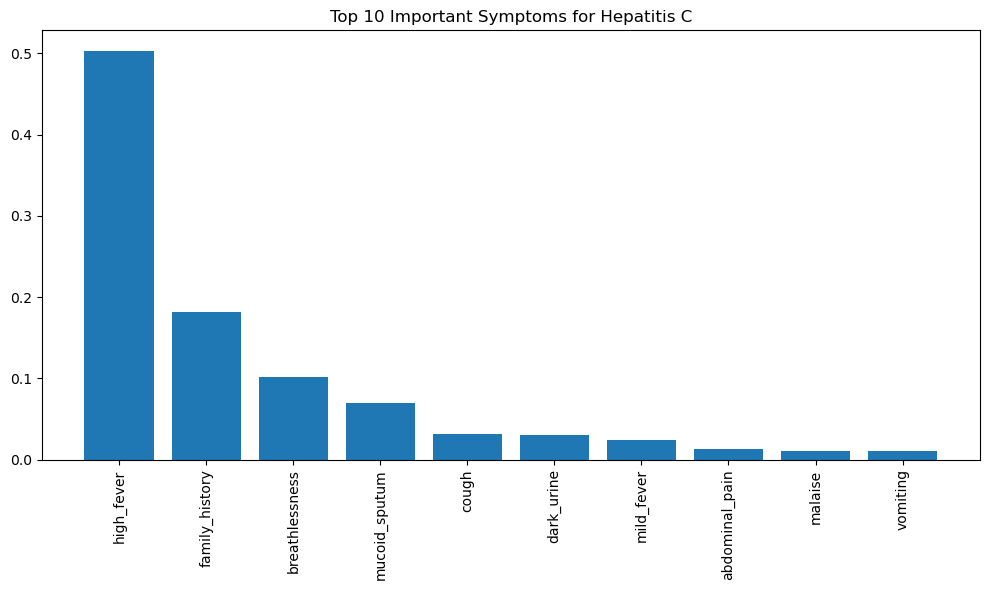

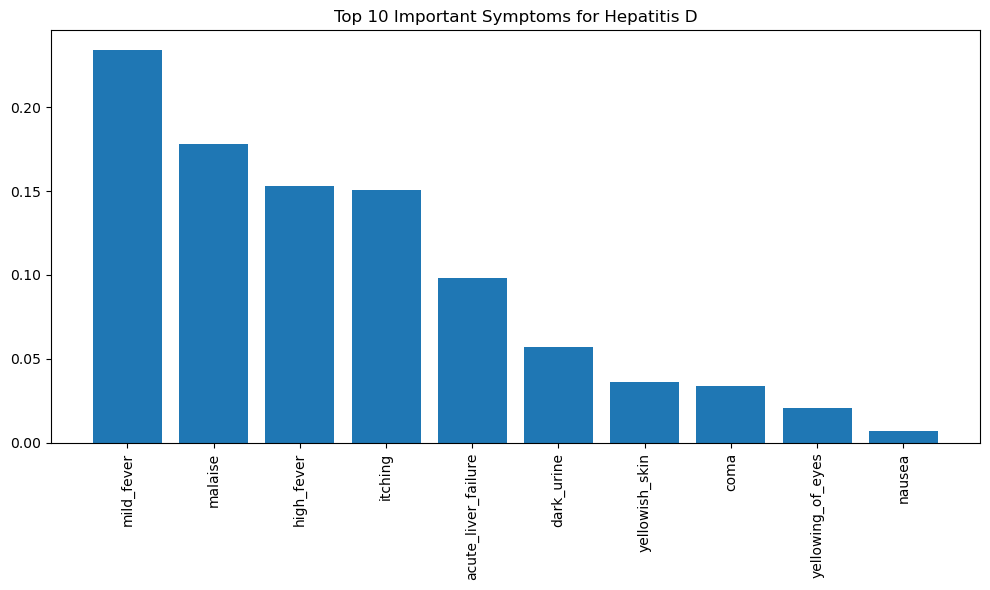

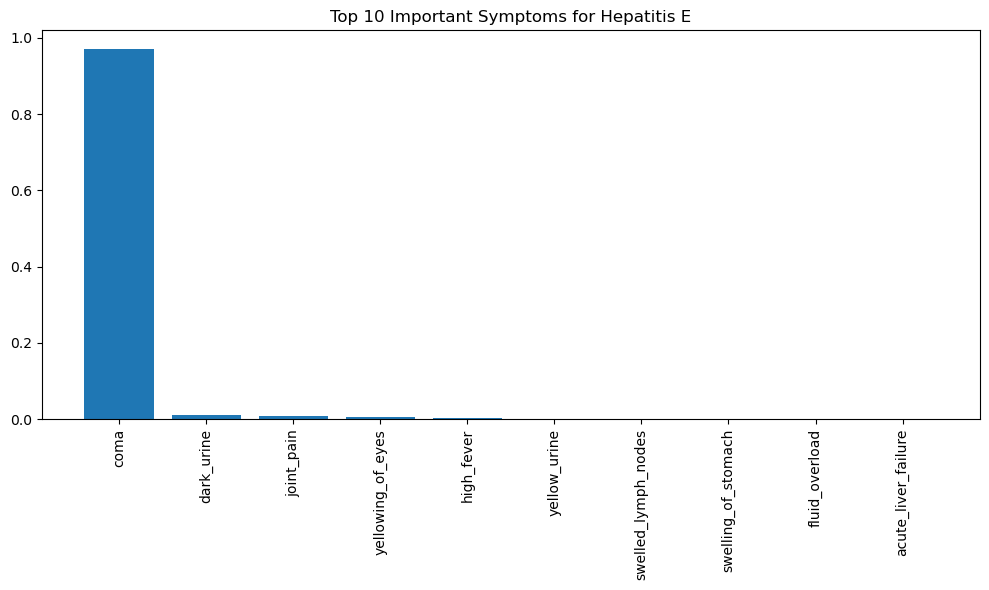

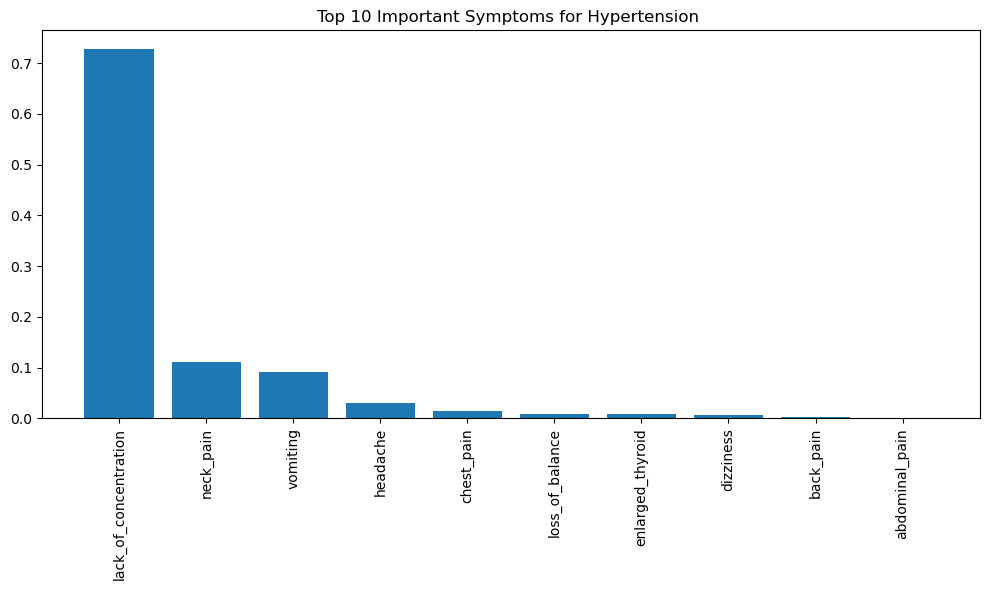

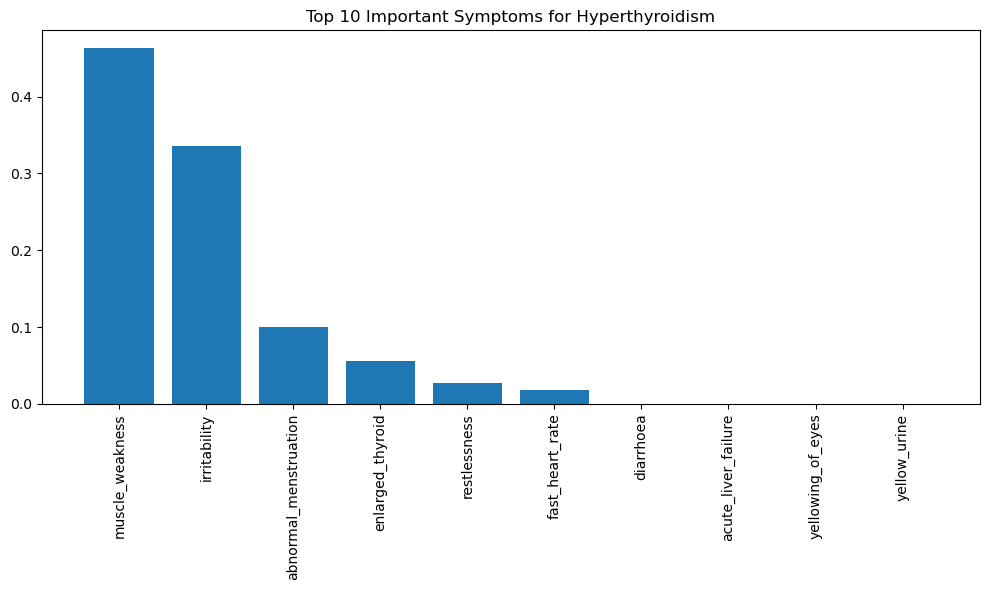

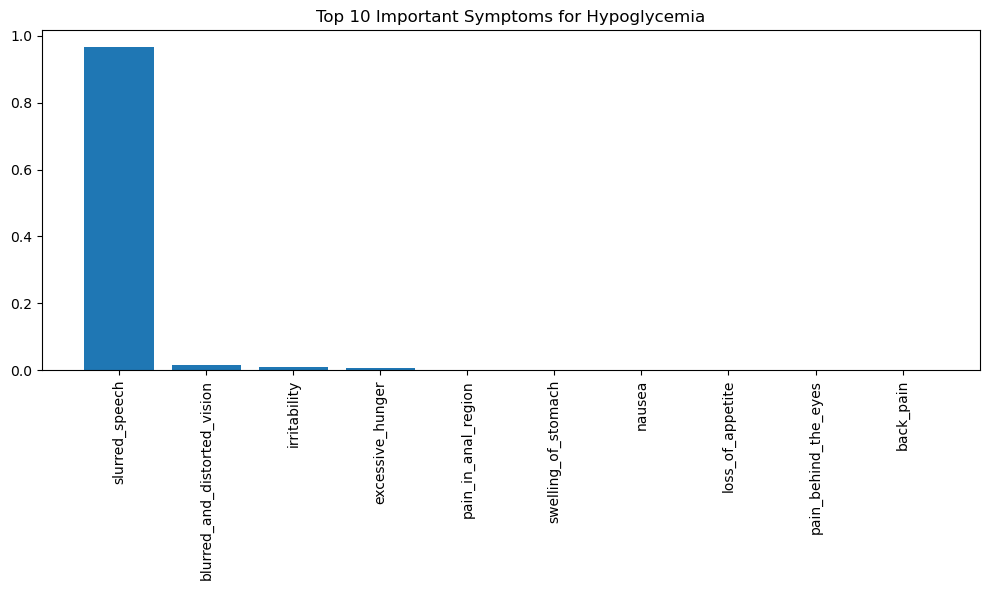

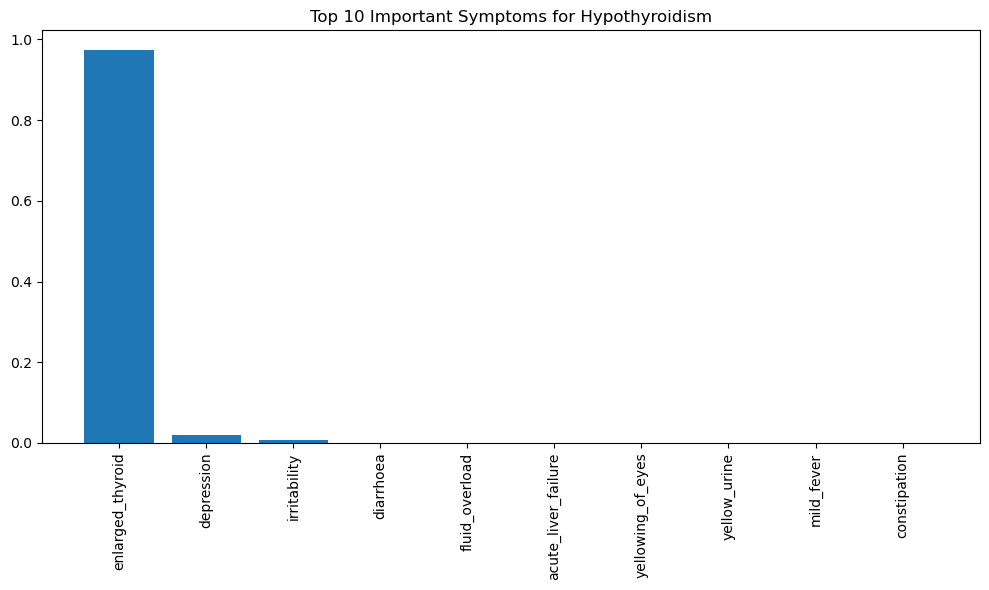

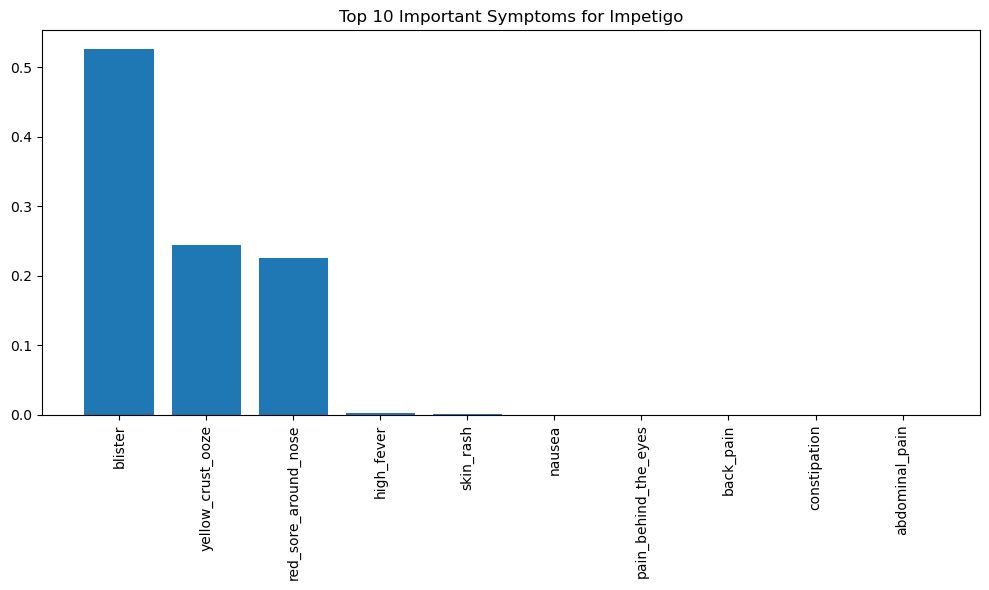

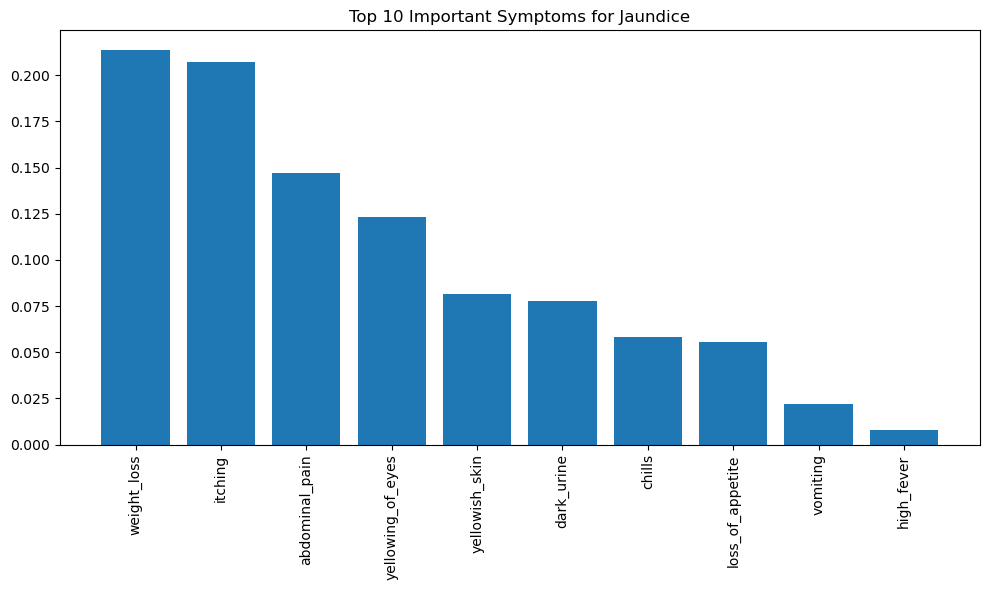

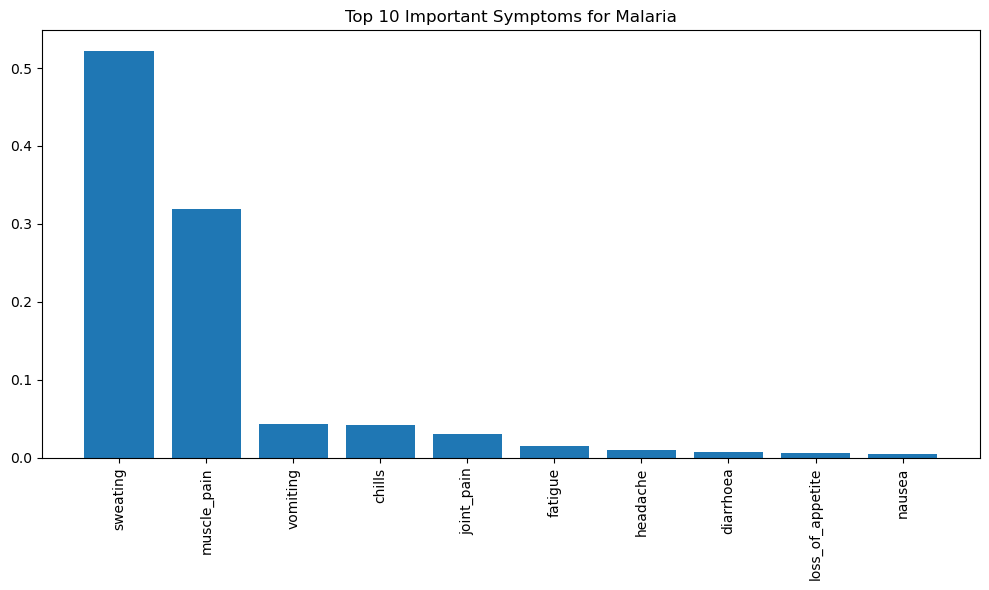

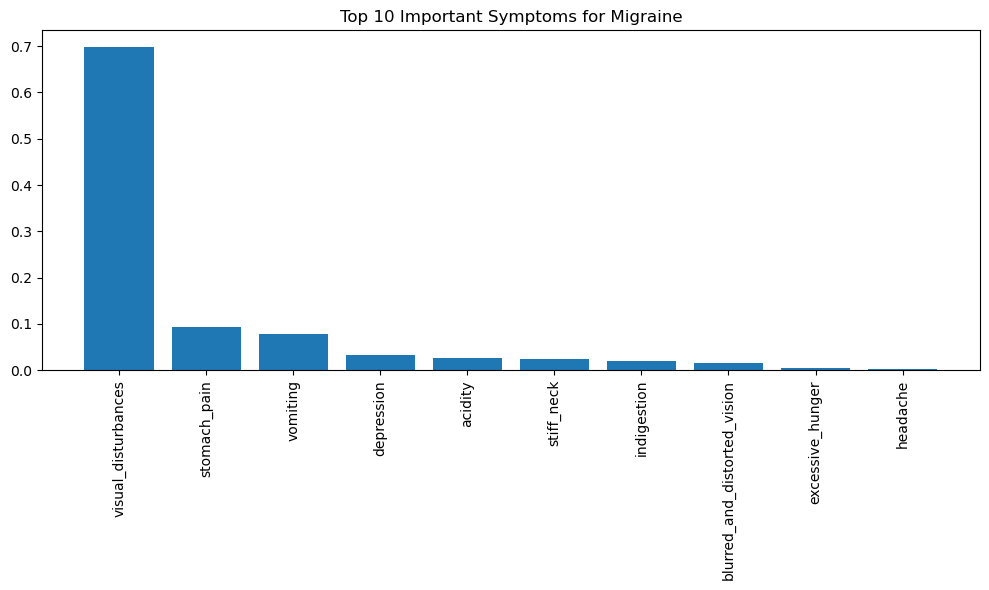

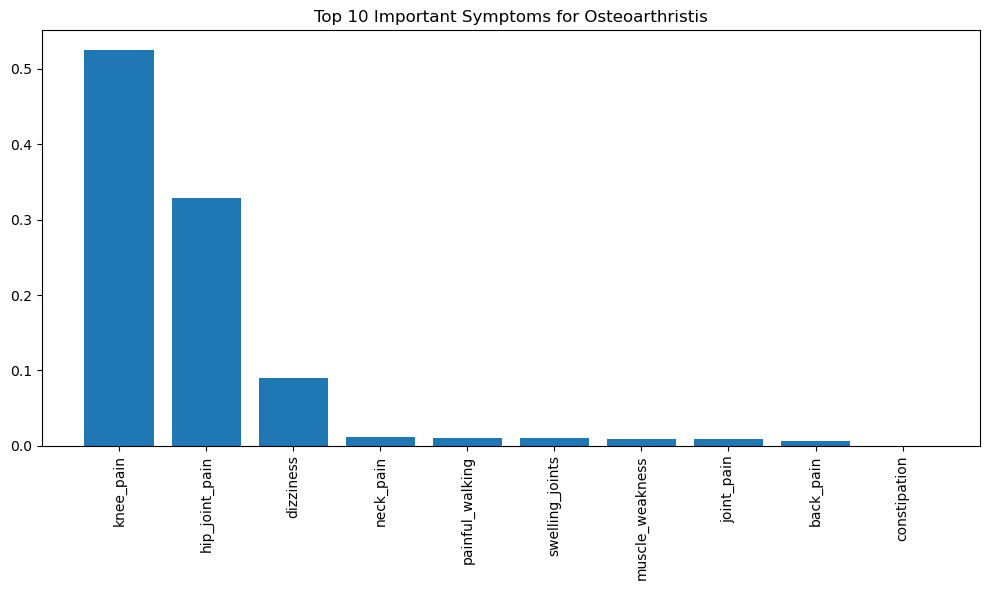

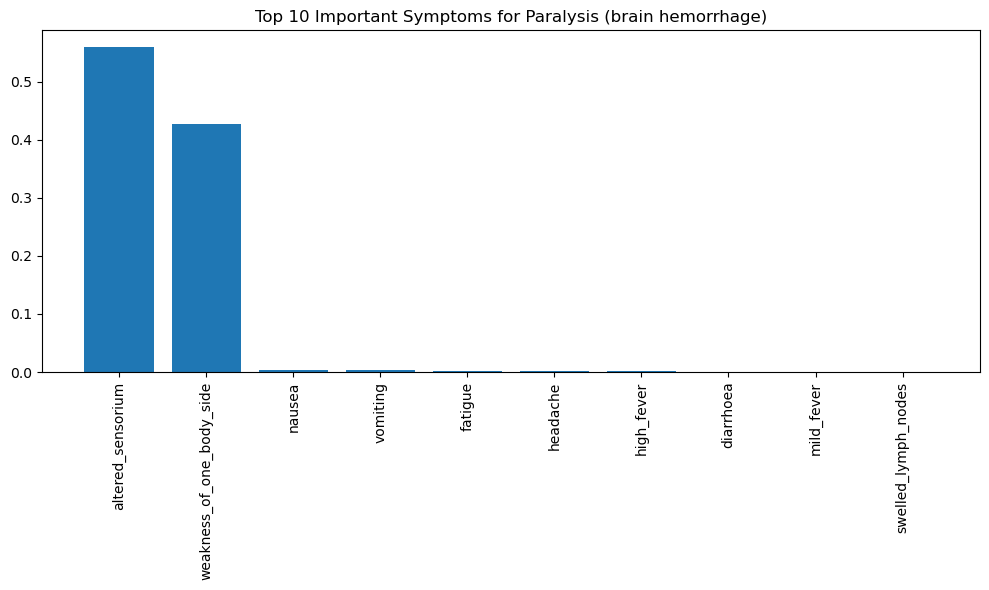

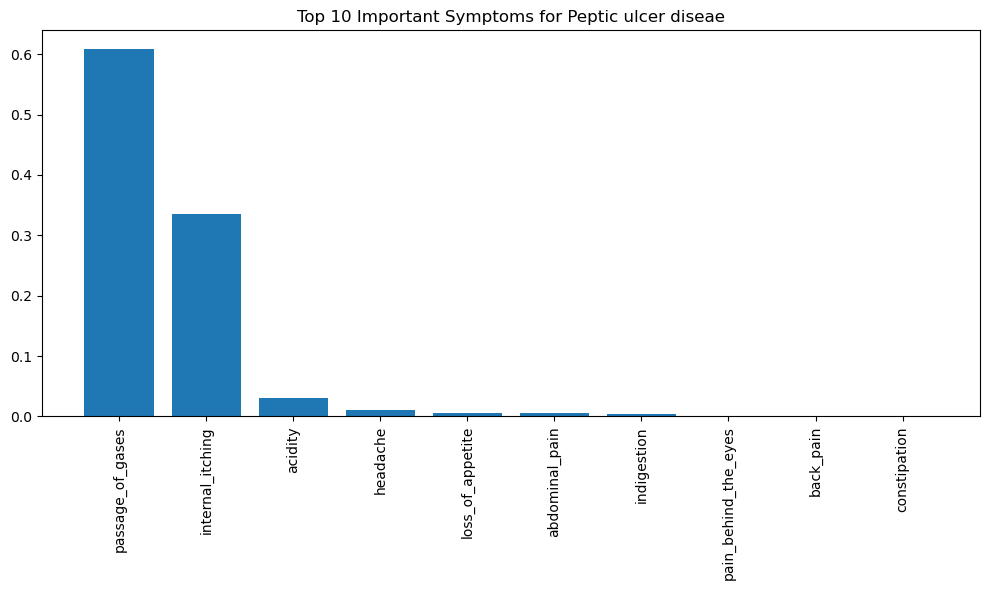

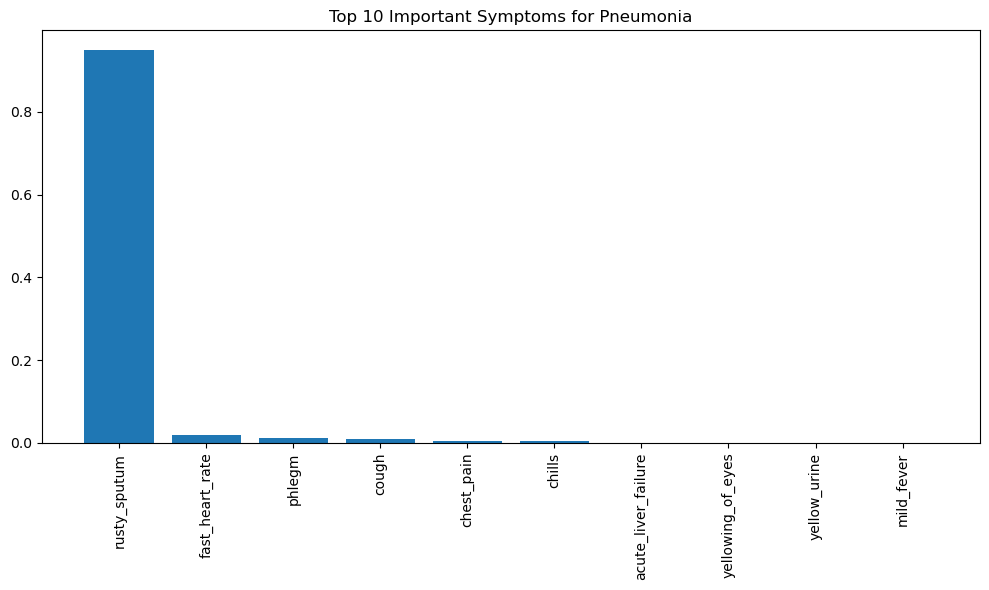

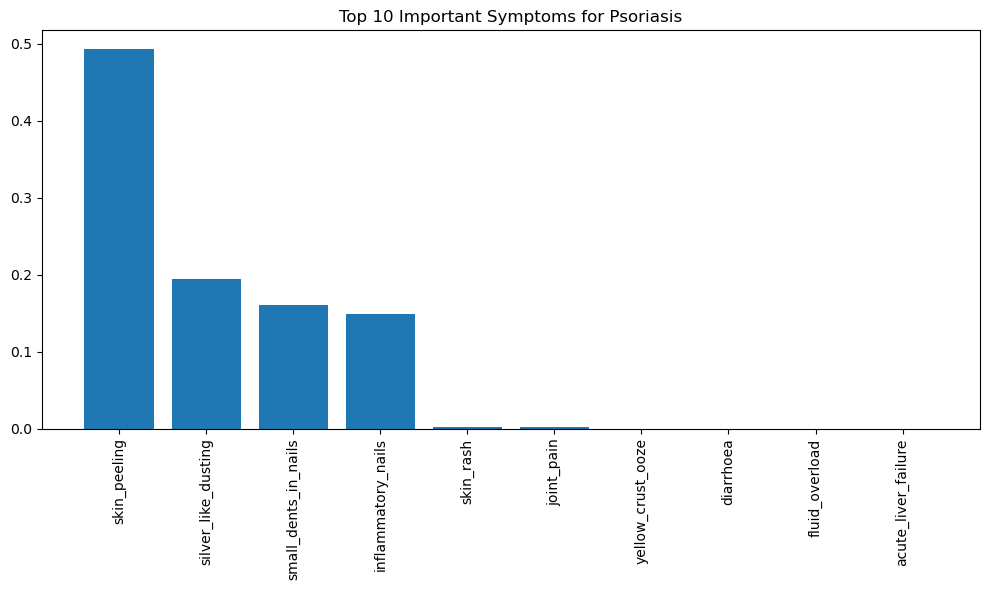

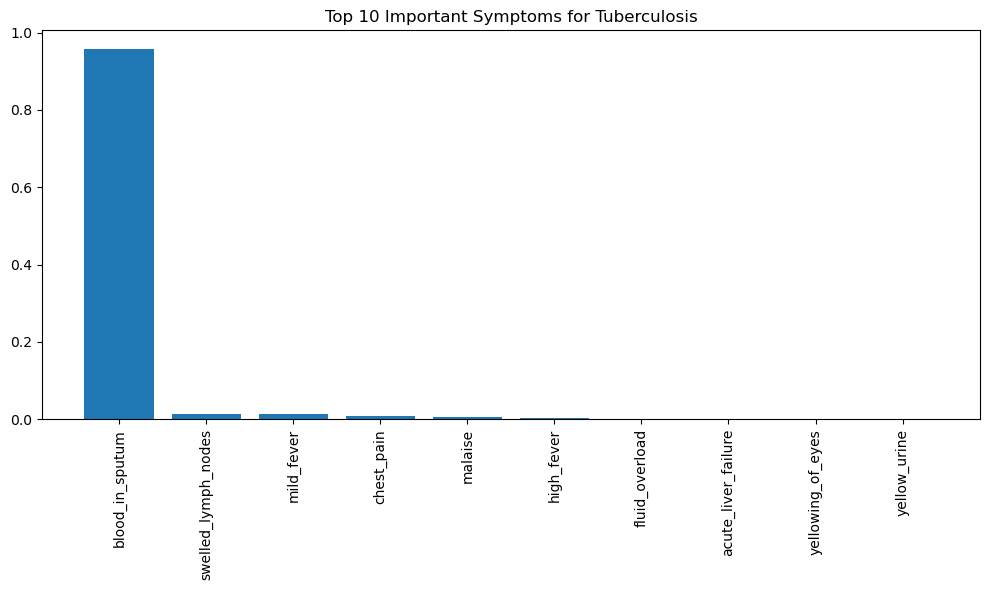

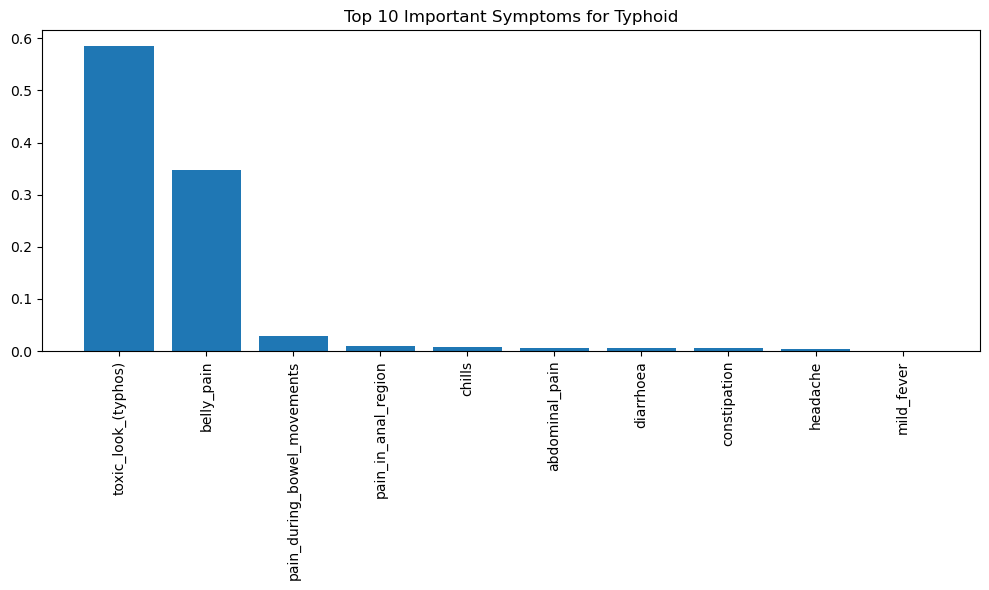

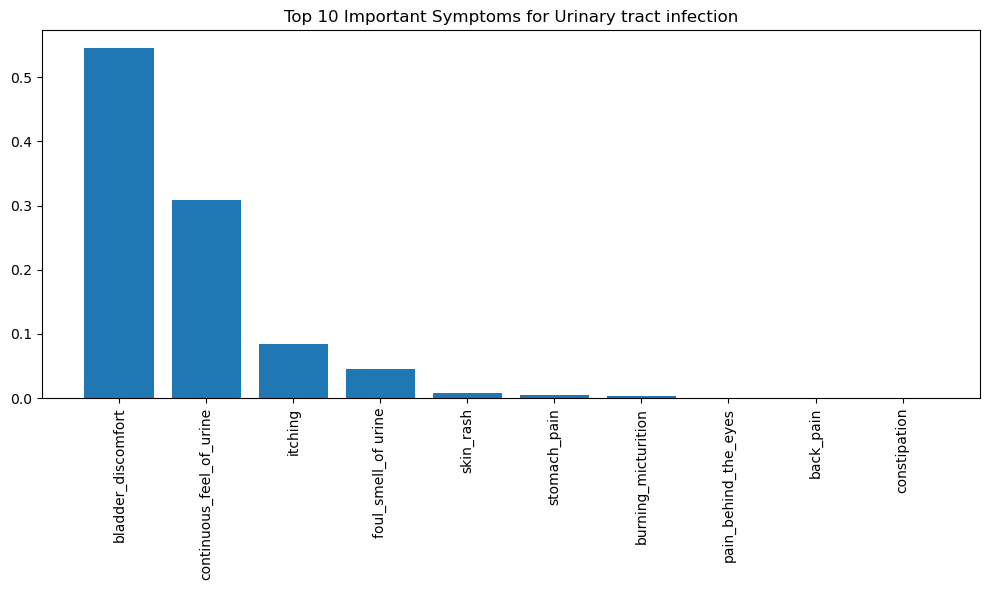

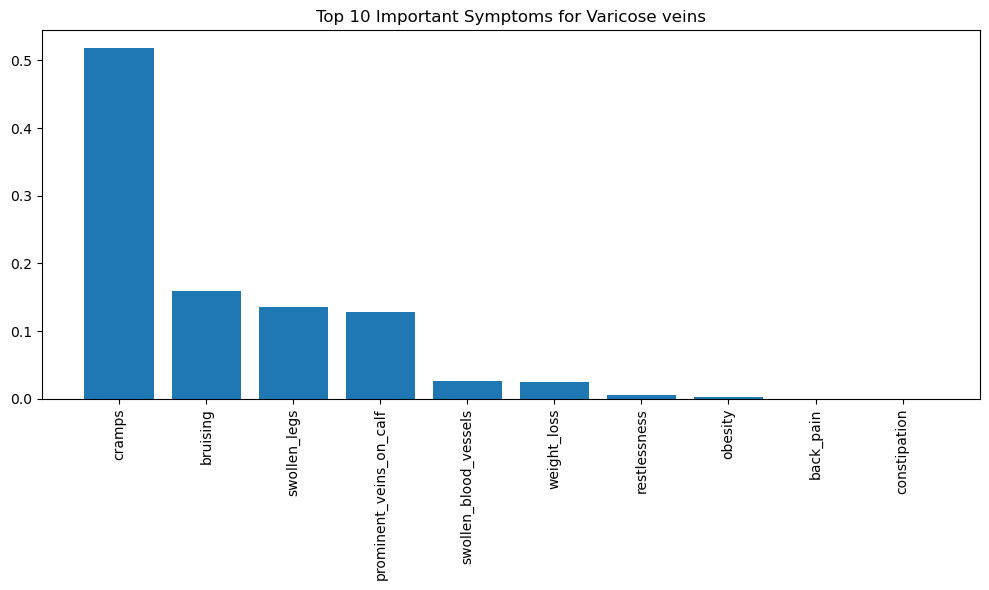

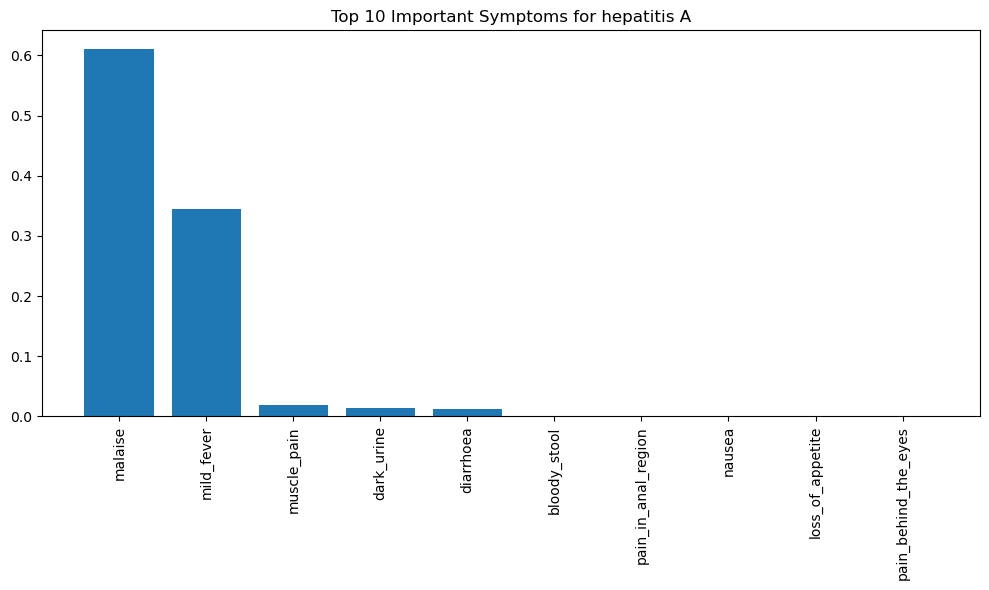

In [9]:
# %%
# Function to plot top N important features for a prognosis
def plot_top_features(model, prognosis_name, n=10):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_features = X_train.columns[indices[:n]]
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Top {n} Important Symptoms for {prognosis_name}")
    plt.bar(range(n), importances[indices[:n]])
    plt.xticks(range(n), top_features, rotation=90)
    plt.tight_layout()
    plt.show()

# Plot top features for each prognosis
for prognosis, model in zip(prognoses, models):
    plot_top_features(model, prognosis)


In [10]:
# %%
# Save evaluation results and feature importances
output_dir = data_dir / 'analysis' / 'xgboost'
eval_df.to_csv(output_dir / 'prognosis_model_evaluations.csv', index=False)
all_importances = pd.DataFrame(
    {prognosis: model.feature_importances_ for prognosis, model in zip(prognoses, models)},
    index=X_train.columns
)
all_importances.to_csv(output_dir / 'symptom_importances_by_prognosis.csv')


